# CV Course Project: Assignment - Image Recognition

---

**Group:**
- Alumno 1: San Millan Rodrigues, Nadine (n.srodrigues@alumnos.upm.es)
- Alumno 2: Sukhorukova, Anastasia (anastasia.s@alumnos.upm.es)
- Alumno 3: Reyes Castro, Didier Yamil (didier.reyes.castro@alumnos.upm.es)

**Course:** Computer Vision (CV) - 2025/26

**Institution:** Polytechnic University of Madrid (UPM)

**Date:** January 2026

---

## Goals

The goals of the assignment are:
* Develop proficiency in using Tensorflow/Keras for training Neural Nets (NNs).
* Put into practice the acquired knowledge to optimize the parameters and architecture of a feedforward Neural Net (ffNN), in the context of an image recognition problem.
* Put into practice NNs specially conceived for analysing images. Design and optimize the parameters of a Convolutional Neural Net (CNN) to deal with previous task.
* Train popular architectures from scratch (e.g., GoogLeNet, VGG, ResNet, ...), and compare the results with the ones provided by their pre-trained versions using transfer learning.

Follow the link below to download the classification data set  “xview_recognition”: [https://drive.upm.es/s/2DDPE2zHw5dbM3G](https://drive.upm.es/s/2DDPE2zHw5dbM3G)

## 0 Setup and Data Loading

### 0.1 Install and Import Required Libraries

In [1]:
!pip install tensorflow numpy rasterio scikit-learn matplotlib keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 80.3 MB/s eta 0:00:00


Loading the necessary libraries.

In [2]:
# Python libraries
import uuid
import warnings
import json
import os
import math

# External libraries
import numpy as np
import rasterio
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Rescaling, BatchNormalization, Dropout, LeakyReLU # type: ignore
from tensorflow.keras.optimizers import Adam, AdamW, SGD
from tensorflow.keras.optimizers.schedules import CosineDecayRestarts
from tensorflow.keras.callbacks import TerminateOnNaN, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


2025-10-15 09:02:53.707676: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760518974.246540      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760518974.377524      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Check if GPU is available for training the models.

In [3]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


### 0.2 Load the Dataset & Image Loader

Before loading the dataset, set the path to the folder containing the images.

In [4]:
IMAGES_PATH = '/kaggle/input/xview-dataset/xview_recognition/'

In [5]:
class GenericObject:
    """
    Generic object data.
    """
    def __init__(self):
        self.id = uuid.uuid4()
        self.bb = (-1, -1, -1, -1)
        self.category= -1
        self.score = -1

class GenericImage:
    """
    Generic image data.
    """
    def __init__(self, filename):
        self.filename = filename
        self.tile = np.array([-1, -1, -1, -1])  # (pt_x, pt_y, pt_x+width, pt_y+height)
        self.objects = list([])

    def add_object(self, obj: GenericObject):
        self.objects.append(obj)

In [6]:
categories = {0: 'Cargo plane', 1: 'Small car', 2: 'Bus', 3: 'Truck', 4: 'Motorboat', 5: 'Fishing vessel', 6: 'Dump truck', 7: 'Excavator', 8: 'Building', 9: 'Helipad', 10: 'Storage tank', 11: 'Shipping container', 12: 'Pylon'}

In [7]:
def load_geoimage(filename):
    warnings.filterwarnings('ignore', category=rasterio.errors.NotGeoreferencedWarning)
    src_raster = rasterio.open(IMAGES_PATH + filename, 'r')
    # RasterIO to OpenCV (see inconsistencies between libjpeg and libjpeg-turbo)
    input_type = src_raster.profile['dtype']
    input_channels = src_raster.count
    img = np.zeros((src_raster.height, src_raster.width, src_raster.count), dtype=input_type)
    for band in range(input_channels):
        img[:, :, band] = src_raster.read(band+1)
    return img

In [8]:
# Load database
json_file = IMAGES_PATH + 'xview_ann_train.json'
with open(json_file) as ifs:
    json_data = json.load(ifs)
ifs.close()

In [9]:
counts = dict.fromkeys(categories.values(), 0)
anns_dataset = []
for json_img, json_ann in zip(json_data['images'].values(), json_data['annotations'].values()):
    image = GenericImage(json_img['filename'])
    image.tile = np.array([0, 0, json_img['width'], json_img['height']])
    obj = GenericObject()
    obj.bb = (int(json_ann['bbox'][0]), int(json_ann['bbox'][1]), int(json_ann['bbox'][2]), int(json_ann['bbox'][3]))
    obj.category = json_ann['category_id']
    # Resampling strategy to reduce training time
    counts[obj.category] += 1
    image.add_object(obj)
    anns_dataset.append(image)
print(counts)

{'Cargo plane': 635, 'Small car': 3324, 'Bus': 1768, 'Truck': 2210, 'Motorboat': 1069, 'Fishing vessel': 706, 'Dump truck': 1236, 'Excavator': 789, 'Building': 3594, 'Helipad': 111, 'Storage tank': 1469, 'Shipping container': 1523, 'Pylon': 312}


In [10]:
def generator_images(objs, batch_size, do_shuffle=False):
    while True:
        if do_shuffle:
            np.random.shuffle(objs)
        groups = [objs[i:i+batch_size] for i in range(0, len(objs), batch_size)]
        for group in groups:
            images, labels = [], []
            for (filename, obj) in group:
                # Load image
                images.append(load_geoimage(filename))
                probabilities = np.zeros(len(categories))
                probabilities[list(categories.values()).index(obj.category)] = 1
                labels.append(probabilities)
            images = np.array(images).astype(np.float32)
            labels = np.array(labels).astype(np.float32)
            yield images, labels

### 0.3 Setup

In [11]:
# Fix random seed for reproducibility
RANDOM_SEED = 42
def set_seed(seed_value):
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)
set_seed(RANDOM_SEED)

# Number of categories for classification
NUM_CATEGORIES = len(categories)

## 1 Model Adjustments

The following architecture is used:
- Validation split: 10% (stratified)
- Input layer: The images are rescaled from [0, 255] to [0, 1]
- Batch: 16
- Epochs: 40
- Layers: 1024 > 512 > 256 > 13
- Activation function: LeakyReLU (negative slope = 0.1)
- Batch Normalization and Dropout (0.2) after each hidden layer.
- Loss function: Categorical Focal Crossentropy
- Optimiser: AdamW (learning rate = 1e-4)

### 1.1 Setup

In [12]:
train2, val2 = train_test_split(anns_dataset,
                                test_size=0.1, 
                                random_state=RANDOM_SEED, 
                                stratify=[obj.category for ann in anns_dataset for obj in ann.objects])
print('Number of training images: ' + str(len(train2)))
print('Number of validation images: ' + str(len(val2)))

Number of training images: 16871
Number of validation images: 1875


In [13]:
# ------ See class distribution in training and validation sets ------
#
#import numpy as np
#import matplotlib.pyplot as plt
#from collections import Counter

# 1. Extract the category labels from your datasets
#train_labels = [obj.category for ann in train2 for obj in ann.objects]
#valid_labels = [obj.category for ann in val2 for obj in ann.objects]

# 2. Count the occurrences of each category
#train_counts = Counter(train_labels)
#valid_counts = Counter(valid_labels)

# 3. Print the counts and proportions
#print("--- Training Set Proportions ---")
#for cat, count in sorted(train_counts.items()):
#    percentage = (count / len(train_labels)) * 100
#    print(f"{cat} | Count: {count:<5} | Percentage: {percentage:.2f}%")

#print("\n--- Validation Set Proportions ---")
#for cat, count in sorted(valid_counts.items()):
#    percentage = (count / len(valid_labels)) * 100
#    print(f"{cat} | Count: {count:<5} | Percentage: {percentage:.2f}%")

In [14]:
print('Compiling the model...')

model = Sequential([
    Input(shape=(224, 224, 3)), # 224x224 images with 3 channels (RGB)
    Rescaling(1./255), # Rescale pixel values to [0, 1]
    Flatten(), # Flatten the 3D tensor to 1D

    Dense(1024, kernel_initializer='he_normal'),
    BatchNormalization(),
    LeakyReLU(negative_slope=0.1),
    Dropout(0.2),
    
    Dense(512, kernel_initializer='he_normal'),
    BatchNormalization(),
    LeakyReLU(negative_slope=0.1),
    Dropout(0.2),

    Dense(256, kernel_initializer='he_normal'),
    BatchNormalization(),
    LeakyReLU(negative_slope=0.1),
    Dropout(0.2),

    Dense(NUM_CATEGORIES, activation='softmax') # Output layer with softmax activation
])

model.summary()


opt =  AdamW(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-8, amsgrad=True, clipnorm=1.0)
model.compile(optimizer=opt, loss='categorical_focal_crossentropy', metrics=['accuracy'])

Compiling the model...


I0000 00:00:1760518995.597206      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1760518995.598040      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 150528)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │   154,141,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 13)             │         3,341 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 154,808,333 (590.55 MB)

 Trainable params: 154,804,749 (590.53 MB)

 Non-trainable params: 3,584 (14.00 KB)

In [15]:
# Callbacks
MODEL_NAME = 'ffNN_model.keras'

model_checkpoint = ModelCheckpoint(MODEL_NAME, monitor='val_accuracy', verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=10, verbose=1)
early_stop = EarlyStopping(monitor='val_accuracy', patience=40, verbose=1)
terminate = TerminateOnNaN()
callbacks = [model_checkpoint, reduce_lr, early_stop, terminate]

In [16]:
# Generate the list of objects from annotations
objs_train = [(ann.filename, obj) for ann in train2 for obj in ann.objects]
objs_valid = [(ann.filename, obj) for ann in val2 for obj in ann.objects]

# Generators
BATCH_SIZE = 16
train_generator = generator_images(objs_train, BATCH_SIZE, do_shuffle=True)
valid_generator = generator_images(objs_valid, BATCH_SIZE, do_shuffle=False)

### 1.2 Training

In [17]:
print('Training model...')

EPOCHS = 40
train_steps = math.ceil(len(objs_train)/BATCH_SIZE)
valid_steps = math.ceil(len(objs_valid)/BATCH_SIZE)

h1 = model.fit(train_generator, 
              steps_per_epoch=train_steps, 
              validation_data=valid_generator, 
              validation_steps=valid_steps, 
              epochs=EPOCHS, 
              callbacks=callbacks, 
              verbose=1)

# Best validation model
best_idx = int(np.argmax(h1.history['val_accuracy']))
best_value = np.max(h1.history['val_accuracy'])
print('Best validation model: epoch ' + str(best_idx+1), ' - val_accuracy ' + str(best_value))

Training model...
Epoch 1/40


I0000 00:00:1760519007.596173      66 service.cc:148] XLA service 0x7ec9c000a0d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1760519007.597874      66 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1760519007.597897      66 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1760519008.301519      66 cuda_dnn.cc:529] Loaded cuDNN version 90300


   1/1055 ━━━━━━━━━━━━━━━━━━━━ 3:29:13 12s/step - accuracy: 0.1250 - loss: 0.7721

I0000 00:00:1760519013.112831      66 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1055/1055 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2802 - loss: 0.4461
Epoch 1: val_accuracy improved from -inf to 0.42613, saving model to ffNN_model.keras
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 1354s 1s/step - accuracy: 0.2803 - loss: 0.4461 - val_accuracy: 0.4261 - val_loss: 0.3016 - learning_rate: 1.0000e-04
Epoch 2/40
1054/1055 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.3834 - loss: 0.3310
Epoch 2: val_accuracy improved from 0.42613 to 0.46720, saving model to ffNN_model.keras
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 127s 121ms/step - accuracy: 0.3834 - loss: 0.3310 - val_accuracy: 0.4672 - val_loss: 0.2746 - learning_rate: 1.0000e-04
Epoch 3/40
1054/1055 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.4143 - loss: 0.3035
Epoch 3: val_accuracy improved from 0.46720 to 0.48693, saving model to ffNN_model.keras
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 119s 113ms/step - accuracy: 0.4143 - loss: 0.3035 - val_accuracy: 0.4869 - val_loss: 0.2616 - learning_rate: 1.0000e-04
Epoch 4/40
1054/1055 ━━━━━━━━━━

- Training time: ~2h:30min
- GPU: Kaggle TP4 x2
- Best validation model: Epoch 31 - Validation accuracy: 0.6165

### 2.3 Validation

In [18]:
def draw_confusion_matrix(cm, categories):
    # Draw confusion matrix
    fig = plt.figure(figsize=[6.4*pow(len(categories), 0.5), 4.8*pow(len(categories), 0.5)])
    ax = fig.add_subplot(111)
    cm = cm.astype('float') / np.maximum(cm.sum(axis=1)[:, np.newaxis], np.finfo(np.float64).eps)
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.colormaps['Blues'])
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), xticklabels=list(categories.values()), yticklabels=list(categories.values()), ylabel='Annotation', xlabel='Prediction')
    # Rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    # Loop over data dimensions and create text annotations
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], '.2f'), ha="center", va="center", color="white" if cm[i, j] > thresh else "black", fontsize=int(20-pow(len(categories), 0.5)))
    fig.tight_layout()
    plt.show()

In [19]:
model.load_weights(MODEL_NAME)
y_true, y_pred = [], []
for ann in val2:
    # Load image
    image = load_geoimage(ann.filename)
    for obj_pred in ann.objects:
        # Generate prediction
        warped_image = np.expand_dims(image, 0)
        predictions = model.predict(warped_image, verbose=0)
        # Save prediction
        pred_category = list(categories.values())[np.argmax(predictions)]
        pred_score = np.max(predictions)
        y_true.append(obj_pred.category)
        y_pred.append(pred_category)

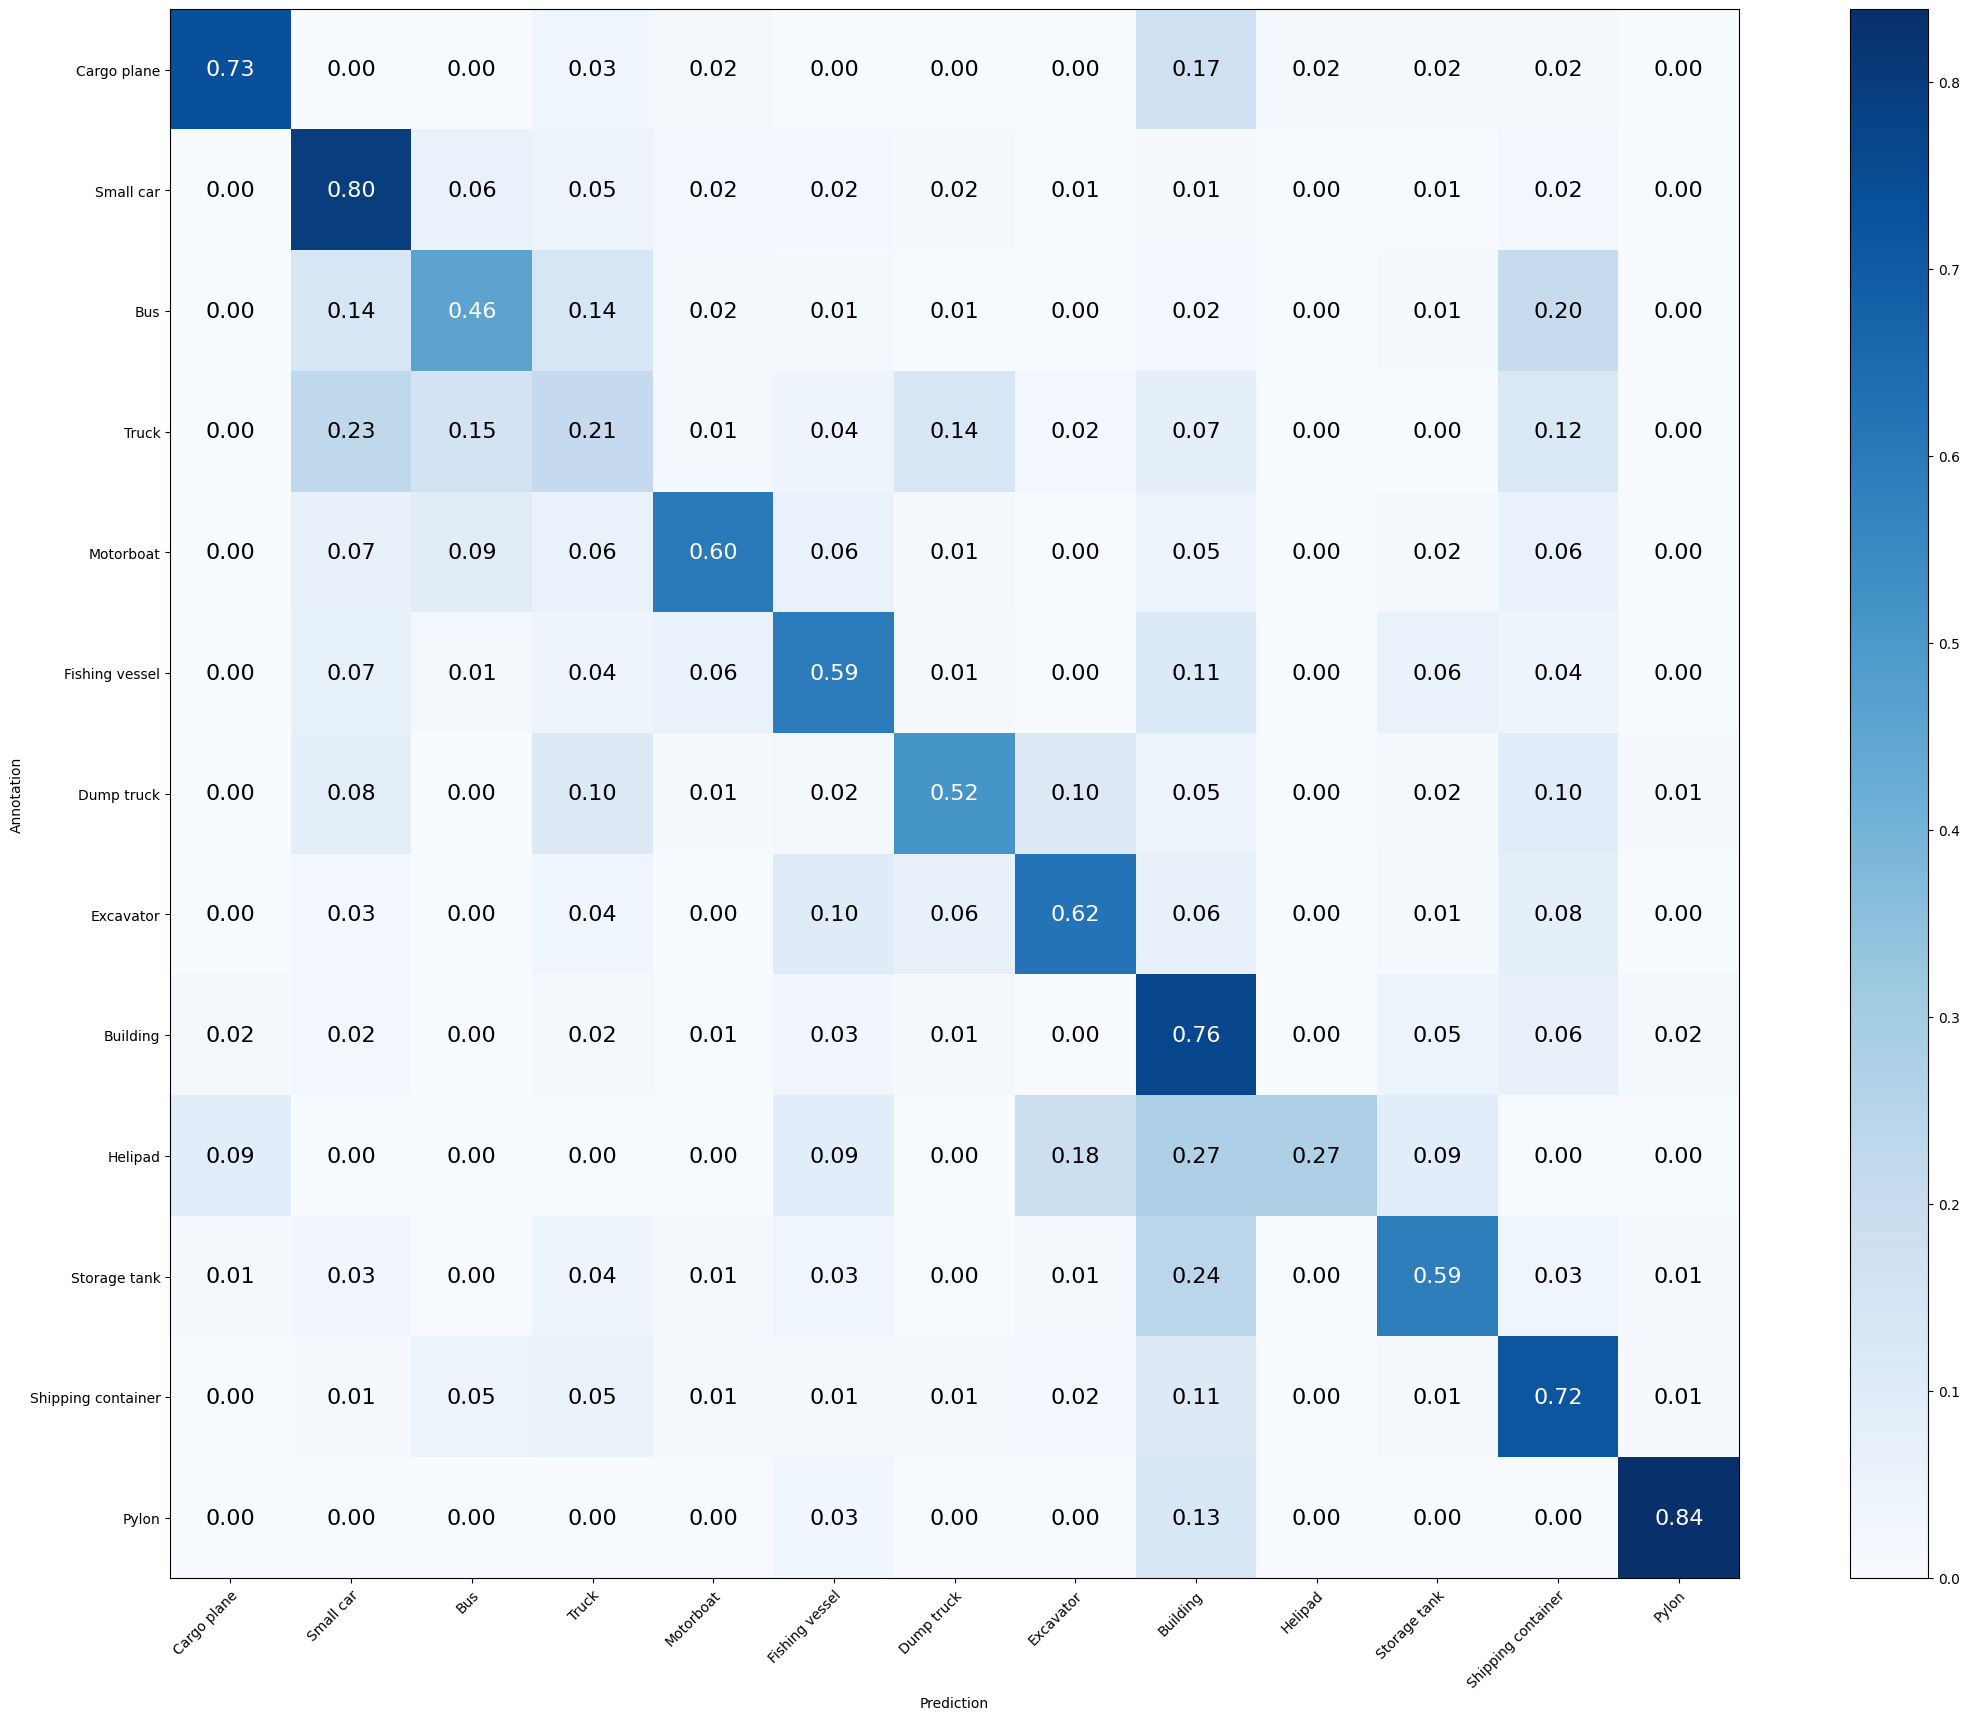

In [20]:
# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=list(categories.values()))
draw_confusion_matrix(cm, categories)

In [21]:
# Compute the accuracy
correct_samples_class = np.diag(cm).astype(float)
total_samples_class = np.sum(cm, axis=1).astype(float)
total_predicts_class = np.sum(cm, axis=0).astype(float)
print('Mean Accuracy: %.3f%%' % (np.sum(correct_samples_class) / np.sum(total_samples_class) * 100))
acc = correct_samples_class / np.maximum(total_samples_class, np.finfo(np.float64).eps)
print('Mean Recall: %.3f%%' % (acc.mean() * 100))
acc = correct_samples_class / np.maximum(total_predicts_class, np.finfo(np.float64).eps)
print('Mean Precision: %.3f%%' % (acc.mean() * 100))
for idx in range(len(categories)):
    # True/False Positives (TP/FP) refer to the number of predicted positives that were correct/incorrect.
    # True/False Negatives (TN/FN) refer to the number of predicted negatives that were correct/incorrect.
    tp = cm[idx, idx]
    fp = sum(cm[:, idx]) - tp
    fn = sum(cm[idx, :]) - tp
    tn = sum(np.delete(sum(cm) - cm[idx, :], idx))
    # True Positive Rate: proportion of real positive cases that were correctly predicted as positive.
    recall = tp / np.maximum(tp+fn, np.finfo(np.float64).eps)
    # Precision: proportion of predicted positive cases that were truly real positives.
    precision = tp / np.maximum(tp+fp, np.finfo(np.float64).eps)
    # True Negative Rate: proportion of real negative cases that were correctly predicted as negative.
    specificity = tn / np.maximum(tn+fp, np.finfo(np.float64).eps)
    # Dice coefficient refers to two times the intersection of two sets divided by the sum of their areas.
    # Dice = 2 |A∩B| / (|A|+|B|) = 2 TP / (2 TP + FP + FN)
    f1_score = 2 * ((precision * recall) / np.maximum(precision+recall, np.finfo(np.float64).eps))
    print('> %s: Recall: %.3f%% Precision: %.3f%% Specificity: %.3f%% Dice: %.3f%%' % (list(categories.values())[idx], recall*100, precision*100, specificity*100, f1_score*100))

Mean Accuracy: 61.653%
Mean Recall: 59.252%
Mean Precision: 61.695%
> Cargo plane: Recall: 73.438% Precision: 83.929% Specificity: 99.503% Dice: 78.333%
> Small car: Recall: 79.518% Precision: 70.400% Specificity: 92.806% Dice: 74.682%
> Bus: Recall: 45.763% Precision: 52.941% Specificity: 95.760% Dice: 49.091%
> Truck: Recall: 21.267% Precision: 35.075% Specificity: 94.740% Dice: 26.479%
> Motorboat: Recall: 59.813% Precision: 71.910% Specificity: 98.586% Dice: 65.306%
> Fishing vessel: Recall: 59.155% Precision: 44.211% Specificity: 97.062% Dice: 50.602%
> Dump truck: Recall: 51.613% Precision: 57.143% Specificity: 97.259% Dice: 54.237%
> Excavator: Recall: 62.025% Precision: 63.636% Specificity: 98.441% Dice: 62.821%
> Building: Recall: 76.323% Precision: 70.256% Specificity: 92.348% Dice: 73.164%
> Helipad: Recall: 27.273% Precision: 60.000% Specificity: 99.893% Dice: 37.500%
> Storage tank: Recall: 58.503% Precision: 71.667% Specificity: 98.032% Dice: 64.419%
> Shipping container:

### 2.4 Testing

In [22]:
anns = []
i = 0
for (dirpath, dirnames, filenames) in os.walk('/kaggle/input/xview-dataset/xview_recognition/xview_test/'):
    for filename in filenames:
        image = GenericImage(dirpath + '/' + filename)
        image.tile = np.array([0, 0, 224, 224])
        obj = GenericObject()
        obj.bb = (0, 0, 224, 224)
        obj.category = dirpath[dirpath.rfind('/')+1:]
        image.add_object(obj)
        anns.append(image)
print('Number of testing images: ' + str(len(anns)))

Number of testing images: 2365


In [23]:
model.load_weights(MODEL_NAME)
predictions_data = {"images": {}, "annotations": {}}

for idx, ann in enumerate(anns):
    image_data = {"image_id": ann.filename.split('/')[-1], "filename": ann.filename, "width": int(ann.tile[2]), "height": int(ann.tile[3])}
    predictions_data["images"][idx] = image_data
    # Load image
    image = load_geoimage("/".join(ann.filename.split('/')[-3:]))
    for obj_pred in ann.objects:
        # Generate prediction
        warped_image = np.expand_dims(image, 0)
        predictions = model.predict(warped_image, verbose=0)
        # Save prediction
        pred_category = list(categories.values())[np.argmax(predictions)]
        pred_score = np.max(predictions)
        annotation_data = {"image_id": ann.filename.split('/')[-1], "category_id": pred_category, "bbox": [int(x) for x in obj_pred.bb]}
        predictions_data["annotations"][idx] = annotation_data

In [24]:
with open("prediction.json", "w") as outfile:
    json.dump(predictions_data, outfile)